In [2]:
!cp drive/MyDrive/natural-language-processing/data.rar .

#### Extracting train/test datasets

In [3]:
!unrar x data.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from data.rar

Extracting  test.rar                                                       0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24%  OK 
Extracting  train.rar                                                     24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91%

In [4]:
!unrar x train.rar -p 


Enter password (will not be echoed): 

Reenter password: 


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from train.rar

Creating    train                                                     OK
Extracting  train/1523MS.wav                                               0%  OK 
Extracting  train/1440FN.wav                                               0%  OK 
Extracting  train/2547FS.wav                                               0%  OK 
Extracting  train/1617MA.wav                                               0%  OK 
Extracting  train/1276MA.wav                                               0%  OK 
Extracting  train/1660MN.wav                                               0%  OK 
Extracting  train/0240MA.wav                                               0%  OK 
Extracting  train/2999MH.wav                                               0%  OK 
Extracting  train/0212FA.wav       

In [5]:
!unrar x test.rar -p


Enter password (will not be echoed): 

Reenter password: 


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from test.rar

Creating    test                                                      OK
Extracting  test/1482.wav                                                  0%  OK 
Extracting  test/1454.wav                                                  0%  OK 
Extracting  test/0172.wav                                                  0%  OK 
Extracting  test/2556.wav                                                  0%  OK 
Extracting  test/0639.wav                                                  0%  OK 
Extracting  test/1037.wav                                                  0%  OK 
Extracting  test/0626.wav                                                  1%  OK 
Extracting  test/1361.wav                                                  1%  OK 
Extracting  test/2401.wav           

#### Importing libraries

In [1]:
# IMPORT NECESSARY LIBRARIES
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.regularizers import l2
import seaborn as sns
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import classification_report

#### Understanding what data is

In [5]:
x, sr = librosa.load('train/0000MA.wav')
# PLAY AUDIO FILE
librosa.output.write_wav('MaleAnger.wav', x, sr)
Audio(data=x, rate=sr)

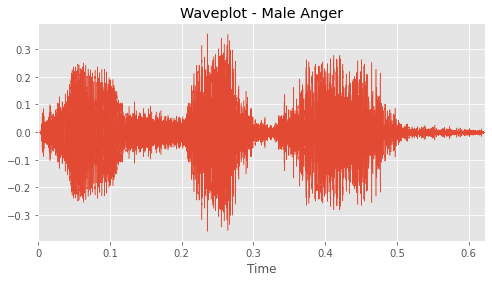

In [6]:
# DISPLAY WAVEPLOT
plt.style.use('ggplot')
plt.figure(figsize=(8, 4))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Male Anger')
plt.savefig('Waveplot_MaleAnger.png')

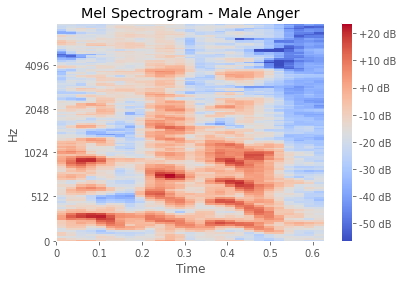

In [9]:
# CREATE LOG MEL SPECTROGRAM
spectrogram = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Anger')
plt.savefig('MelSpec_MaleAnger.png')
plt.colorbar(format='%+2.0f dB');

#### Feature extraction 
- MFCC
- Chroma
- Melspectrogram

In [10]:
!pip install soundfile

In [2]:
#DataFlair - Extract features (mfcc, chroma, mel) from a sound file
import soundfile
import glob
from sklearn.model_selection import train_test_split

# function default argument
def extract_feature(file_name, mfcc=True, chroma=True, mel=True):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
    return result
  

# DataFlair - Load the data and extract features for each sound file
# Use of three features
def load_data(test_size=0.2):
    x,y=[],[]
    for f in glob.glob("train/*.wav"):
        file_name = os.path.basename(f)
        emotion = file_name.split(".wav")[0][-1]
        feature = extract_feature(f)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size)

def load_data_test():
    x = []
    for f in glob.glob("test/*.wav"):
        file_name = os.path.basename(f)
        feature = extract_feature(f)
        x.append(feature)
    return np.array(x)

x_train, x_val, y_train, y_val = load_data(test_size=0.2)
x_test = load_data_test()

In [3]:
#Get the shape of the training and testing datasets
print((x_train.shape, x_val.shape), np.array(x_test).shape)

((1776, 180), (445, 180)) (741, 180)


#### Dataset distribution
- dataset is skewed

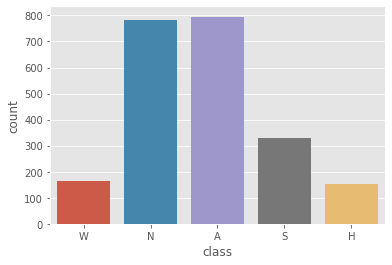

In [7]:
import seaborn as sns
df = pd.DataFrame(np.hstack([y_train, y_val]), columns=['class'])
sns.countplot(x=df['class'], data=df);

In [43]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights_dict = {np.unique(y_train)[i]: class_weights[i] for i in range(len(class_weights))}
class_weights_dict

{'A': 0.5447852760736196,
 'H': 3.0358974358974358,
 'N': 0.5738287560581583,
 'S': 1.3984251968503938,
 'W': 2.6507462686567163}

#### Model preparation

In [62]:
from sklearn import tree
from sklearn.svm import SVC
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from warnings import filterwarnings
filterwarnings('ignore')
# clf = SVC(kernel='linear', probability=True, class_weight=class_weights_dict)
# clf = tree.DecisionTreeClassifier()
#
clf = LogisticRegression()
clf = clf.fit(x_train, y_train)
prediction = clf.predict(x_val)
print(f"weighted f1-score: {f1_score(y_val, prediction, average='weighted')}")

weighted f1-score: 0.6721325068910856


#### Prediction

In [63]:
pred = clf.predict_proba(np.array(x_test))
submit_df = pd.DataFrame(pred, columns=['A','H','N','S','W'])
submit_df.to_csv('out.csv')